In [2]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate

plt.rcParams["figure.figsize"] = [14, 5]
# sns.set(rc={'figure.figsize':(14,5)})

color_palette = {
    'MVERegression': '#1f77b4',  # Blue
    'QuantileRegression': '#ff7f0e',  # Orange
    'DKLRegression': '#2ca02c',  # Green
    'LaplaceRegression': '#d62728',  # Red
    'DeepEnsembleRegression': '#9467bd',  # Purple
    'MCDropoutRegression': '#8c564b',  # Brown
    'SWAGRegression': '#e377c2',  # Pink
    'BNN_VI_ELBO_Regression': '#7f7f7f',  # Gray
    'DER': '#bcbd22',  # Lime
    'DUERegression': '#17becf',  # Teal
    'DeterministicRegression': '#aec7e8', # Light Blue
    'ConformalQR': '#ffbb78',  # Light Orange
    "CARDRegression": "#98df8a"
}

%load_ext autoreload
%autoreload 2

In [3]:
# specify directories to include in analysis
directories = [
    "/p/project/hai_uqmethodbox/experiment_output/sgd_check",
]
paths = [file for directory in directories for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))]



# selective prediction threshold
SELECTIVE_THRESH = 9

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "tropical_depression": (0, 33),
    "tropical_storm": (34, 63),
    "hurr_1": (64, 82),
    "hurr_2": (83, 95),
    "hurr_3": (96, 112),
    "hurr_4": (113, 136),
    "hurr_5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "absolute"

In [4]:
paths

['/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DER_12-15-2023_21-38-59-545084/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DER_12-15-2023_21-38-59-545084/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DER_12-15-2023_21-38-59-545084/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_MVERegression_12-15-2023_21-38-59-545077/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_MVERegression_12-15-2023_21-38-59-545077/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_MVERegression_12-15-2023_21-38-59-545077/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_MCDropoutRegression_12-18-2023_10-38-37-639748/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_MCDropoutRegression_12-18-2023_10-38-37-639748/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_outp

## Util functions

## get normaliation params

In [5]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule
    
    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()

def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, 'config.yaml'))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap(get_normalization_params_from_df_wrapper, paths), total=len(paths)))
    results = {k: v for result in results if result is not None for k, v in result.items()}
    return results

num_processes = 8
dir_paths = list(set([os.path.dirname(path) for path in paths]))
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(dir_paths, num_processes)

  0%|          | 0/12 [00:00<?, ?it/s]

Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589
Num samples: 46589


  8%|▊         | 1/12 [00:59<10:52, 59.31s/it]

Num samples: 46589


 58%|█████▊    | 7/12 [01:09<00:31,  6.21s/it]

Num samples: 46589
Num samples: 46589


 75%|███████▌  | 9/12 [01:18<00:21,  7.27s/it]

Num samples: 46589
Num samples: 46589


100%|██████████| 12/12 [01:19<00:00,  6.60s/it]


In [6]:
NORMALIZATION_PARAMS

{'/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_QuantileRegression_12-15-2023_13-57-24-983419': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_LaplaceRegression_12-18-2023_16-53-17-587750': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_BNN_VI_ELBO_Regression_12-18-2023_10-38-37-639752': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_SWAGRegression_12-18-2023_16-32-27-703926': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_BNN_VI_ELBO_Regression_12-18-2023_14-02-00-546202': {'target_mean': 61.754425048828125,
  'target_std': 25.530269622802734},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_De

## selective prediction thresholds based on validation set

In [8]:
def compute_quantile_and_save(paths: list[str], quantile: float = 0.9):
    selective_pred_dict = {}
    for path in paths:
        assert "val" in path
        df = pd.read_csv(path)

        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_std"]
            TARGET_MEAN = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_mean"]
            df["pred_uct"] = df["pred_uct"] * TARGET_STD
            df["target"] = df["target"] * TARGET_STD + TARGET_MEAN
            # threshold = np.quantile(df['pred_uct'], quantile)
            df['storm_category'] = pd.cut(df['target'], bins=BIN_EDGES, labels=CLASS_LABELS, right=False)
            if SELECTIVE_PROCEDURE == "absolute":
                # create a dict over all storm categories and fill values with absolute threshold
                thresholds = {category: SELECTIVE_THRESH for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "method":
                # create a dict over all storm categories and fill values with method threshold, independent of category
                method_threshold = df["pred_uct"].quantile(quantile)
                thresholds = {category: method_threshold for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "category_conditional":
                thresholds = df.groupby('storm_category', observed=False)['pred_uct'].quantile(quantile).to_dict()
        else:
            continue

        selective_pred_dict[os.path.dirname(path)] = thresholds
    return selective_pred_dict

dir_paths = [path for path in paths if "val" in path]
SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths, 0.8)
SELECTIVE_PRED_DICT
        

{'/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DER_12-15-2023_21-38-59-545084': {'tropical_depression': 9,
  'tropical_storm': 9,
  'hurr_1': 9,
  'hurr_2': 9,
  'hurr_3': 9,
  'hurr_4': 9,
  'hurr_5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_MVERegression_12-15-2023_21-38-59-545077': {'tropical_depression': 9,
  'tropical_storm': 9,
  'hurr_1': 9,
  'hurr_2': 9,
  'hurr_3': 9,
  'hurr_4': 9,
  'hurr_5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_MCDropoutRegression_12-18-2023_10-38-37-639748': {'tropical_depression': 9,
  'tropical_storm': 9,
  'hurr_1': 9,
  'hurr_2': 9,
  'hurr_3': 9,
  'hurr_4': 9,
  'hurr_5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DeepEnsembleRegression_12-18-2023_16-22-01-773164': {'tropical_depression': 9,
  'tropical_storm': 9,
  'hurr_1': 9,
  'hurr_2': 9,
  'hurr_3': 9,
  'hurr_4': 9,
  'hurr_5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/sgd_check/cy

In [9]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]
        
        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, '%m-%d-%Y')
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = path.replace("preds.csv", "config.yaml")
        exp_dict["metric_path"] = os.path.join(os.path.dirname(path), "csv_logs", "version_0", "metrics.csv")
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df

overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,DER,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
1,DER,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
2,DER,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
3,MVERegression,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
4,MVERegression,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
5,MVERegression,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
6,MCDropoutRegression,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
7,MCDropoutRegression,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
8,MCDropoutRegression,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...
9,DeepEnsembleRegression,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...,/p/project/hai_uqmethodbox/experiment_output/s...


In [10]:
empty_result = {'accuracy': {'mae': np.nan, 'rmse': np.nan, 'mdae': np.nan, 'marpd': np.nan, 'r2': np.nan, 'corr': np.nan}, 'avg_calibration': {'rms_cal': np.nan, 'ma_cal': np.nan, 'miscal_area': np.nan}, 'sharpness': {'sharp': np.nan}, 'scoring_rule': {'nll': np.nan, 'crps': np.nan, 'check': np.nan, 'interval': np.nan}}
def compute_metrics_for_predictions(csv_path: str, selective_pred: bool, normalized: bool = False) -> pd.DataFrame:
    """Compute metrics for prediction file.

    Args:
        save_dir: path_to_csv
        selective_pred: whether or not to apply selective prediction

    Returns:
        dataframe with computed metrics
    """
    pred_df = pd.read_csv(csv_path)

    # get normalization parameters
    TARGET_MEAN, TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_mean"], NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_std"]
                                                              
    # unnormalize data
    if not normalized:
        pred_df["pred"] = (pred_df["pred"] * TARGET_STD) + TARGET_MEAN
        pred_df["target"] = (pred_df["target"] * TARGET_STD) + TARGET_MEAN

    # Apply the storm category
    pred_df['storm_category'] = pd.cut(pred_df['target'], bins=BIN_EDGES, labels=CLASS_LABELS, right=False)
    # count number of observations per category
    count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

    if "pred_uct" in pred_df.columns:

        if not normalized:
            pred_df["pred_uct"] = pred_df["pred_uct"] * TARGET_STD

        if selective_pred:
            # Filter the DataFrame to exclude the top 10% highest values
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_THRESH]
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)]]
            grouped = pred_df.groupby('storm_category', observed=False)

            # Apply the selective prediction filter to each group
            pred_df = grouped.apply(lambda group: group[group["pred_uct"] <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)][group.name]])

            # Reset the index of the DataFrame
            pred_df.reset_index(drop=True, inplace=True)
            # number of observations per category afterwards
            count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

        if len(pred_df) > 0:  
            uq_metrics = uct.metrics.get_all_metrics(
                pred_df["pred"].values.squeeze(),
                pred_df["pred_uct"].values.squeeze(),
                pred_df["target"].values.squeeze(),
                verbose=False,
            )
        else:
            # TODO: What to do if all metrics are removed
            uq_metrics = empty_result
        # categories when predictive uncertainty is present
        uq_metric_categories = ["scoring_rule", "avg_calibration", "sharpness", "accuracy"]

    else:
        # categories when no predictive uncertainty is present
        uq_metric_categories = ["accuracy"]
        uq_metrics = {"accuracy": uct.metrics.get_all_accuracy_metrics(pred_df["pred"].values.squeeze(), pred_df["target"].values.squeeze())}

    # collect metrics
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}

    # mulit column df holding the results
    df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T

    # drop multilevel
    df.columns = df.columns.droplevel(0)

    # case if empty results have to handle manually since dict of nan just creates empty df
    if df.empty:
        # Flatten the dictionary keys
        flattened_keys = [f'{inner_key}' for outer_key, inner_dict in empty_result.items() for inner_key in inner_dict.keys()]
        # Create DataFrame
        df = pd.DataFrame(columns=flattened_keys)
        # Fill DataFrame with NaNs
        df.loc[0] = np.nan

    df["split"] = csv_path.split(os.sep)[-1].split(".")[0]
    df["pred_path"] = csv_path

    # count 
    count_df = pd.DataFrame(count_per_cat).transpose().reset_index()
    count_df = count_df[count_df.columns.intersection(CLASS_LABELS)]
    count_df["count_total"] = count_df.sum(axis=1)
    df = pd.concat([df, count_df], axis=1)
    return df

In [11]:
def compute_metrics_for_predictions_wrapper(path, selective_pred, normalised):
    try:
        return compute_metrics_for_predictions(path, selective_pred, normalised)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None
    
def compute_uncertainty_df(overview_df):
    def parallel_process(paths: List[str], num_processes: int, selective_pred: bool, normalised: bool):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        # result_dfs = pool.starmap(compute_metrics_for_predictions, [(path, selective_pred, normalised) for path in paths])
        results = pool.starmap(compute_metrics_for_predictions_wrapper, [(path, selective_pred, normalised) for path in paths])
        # Filter out None results
        result_dfs = [result for result in results if result is not None]
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        combined_df = pd.concat(result_dfs, ignore_index=True)
        return combined_df

    # Assuming 'df' is your original DataFrame with the path column
    # Extract the paths from the DataFrame column
    paths = overview_df['pred_path'].tolist()

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities

    # Call the parallel_process function to execute the processing in parallel
    uqmetric_df = parallel_process(paths, num_processes, selective_pred=False, normalised=False)
    selective_df = parallel_process(paths, num_processes, selective_pred=True, normalised=False)

    # merge model name column
    uqmetric_df = pd.merge(left=uqmetric_df, right=overview_df[["pred_path", "uqmethod"]], how="left", left_on="pred_path", right_on="pred_path")
    selective_df = pd.merge(left=selective_df, right=overview_df[["pred_path", "uqmethod"]], how="left", left_on="pred_path", right_on="pred_path")

    return uqmetric_df, selective_df


uq_metric_df, selective_df = compute_uncertainty_df(overview_df)

uq_metric_df, selective_df

 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
Error processing /p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_SWAGRegression_12-18-2023_16-32-27-703926/preds_val.csv: All inputs must be 1d numpy.ndarray


(           nll       crps     check   interval   rms_cal    ma_cal  \
 0     4.606573  10.223162  5.161234  64.138574  0.377866  0.333156   
 1     4.598467   9.949671  5.023109  63.515237  0.405641  0.356216   
 2     4.602965  10.235908  5.167684  63.971199  0.375018  0.330531   
 3     3.756191   5.912059  2.985064  29.477296  0.003937  0.003343   
 4     3.882525   5.375776  2.714409  26.542223  0.020427  0.017806   
 5   543.604362   6.154736  3.106996  31.449003  0.025208  0.023475   
 6     3.807661   5.949520  3.004106  30.009727  0.101929  0.089769   
 7     3.714017   5.100492  2.575299  27.147591  0.180817  0.161358   
 8     3.854889   6.404481  3.233859  32.040364  0.080925  0.070172   
 9     3.798193   5.246180  2.648789  29.065475  0.226398  0.202571   
 10    3.808696   5.423820  2.738503  29.573563  0.209627  0.186372   
 11    4.055760   7.960838  4.019659  39.625353  0.049597  0.041639   
 12         NaN        NaN       NaN        NaN       NaN       NaN   
 13   

In [12]:
with pd.option_context('display.max_colwidth', None):
    display(uq_metric_df[uq_metric_df["uqmethod"]=="DeepEnsembleRegression"][["pred_path","split", "rmse", "nll", "crps", "sharp"]])

,pred_path,split,rmse,nll,crps,sharp
9,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DeepEnsembleRegression_12-18-2023_16-22-01-773164/preds_val.csv,preds_val,8.284360,3.798193,5.246180,15.910788
10,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DeepEnsembleRegression_12-18-2023_16-22-01-773164/preds_train.csv,preds_train,8.883890,3.808696,5.423820,15.898227
11,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DeepEnsembleRegression_12-18-2023_16-22-01-773164/preds.csv,preds,14.555974,4.055760,7.960838,15.901185


# Diff Selective Prediction Effect

This Table shows the performance improvement in metrics after applying selective prediction.

In [13]:
diff_df = pd.DataFrame()

# Iterate over each column in the dataframes
for column in uq_metric_df.columns:
    # Check if the column contains numerical values
    if pd.api.types.is_numeric_dtype(uq_metric_df[column]):
        # Assign the difference to the new dataframe
        diff_df[column] = uq_metric_df[column] - selective_df[column]
    else:
        # If the column contains non-numerical values, assign the values from df1 to the new dataframe
        diff_df[column] = uq_metric_df[column]

display(diff_df[diff_df["split"]=="preds"][["uqmethod", "split", "nll", "sharp", "mae", "rmse", "pred_path"]])

,uqmethod,split,nll,sharp,mae,rmse,pred_path
2,DER,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/s...
5,MVERegression,preds,-801.295270,2.775026,2.209631,2.888098,/p/project/hai_uqmethodbox/experiment_output/s...
8,MCDropoutRegression,preds,0.239068,5.907395,2.655992,2.550993,/p/project/hai_uqmethodbox/experiment_output/s...
11,DeepEnsembleRegression,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/s...
14,DeterministicRegression,preds,NaN,NaN,0.000000,0.000000,/p/project/hai_uqmethodbox/experiment_output/s...
17,QuantileRegression,preds,0.156357,2.516377,1.798174,2.264488,/p/project/hai_uqmethodbox/experiment_output/s...
20,LaplaceRegression,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/s...
23,DUERegression,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/s...
26,BNN_VI_ELBO_Regression,preds,0.068595,1.686311,1.229844,1.731991,/p/project/hai_uqmethodbox/experiment_output/s...
29,SWAGRegression,preds,0.086673,8.181470,0.638874,1.236257,/p/project/hai_uqmethodbox/experiment_output/s...


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'DER'),
  Text(1, 0, 'MVERegression'),
  Text(2, 0, 'MCDropoutRegression'),
  Text(3, 0, 'DeepEnsembleRegression'),
  Text(4, 0, 'DeterministicRegression'),
  Text(5, 0, 'QuantileRegression'),
  Text(6, 0, 'LaplaceRegression'),
  Text(7, 0, 'DUERegression'),
  Text(8, 0, 'BNN_VI_ELBO_Regression'),
  Text(9, 0, 'SWAGRegression'),
  Text(10, 0, 'DKLRegression')])

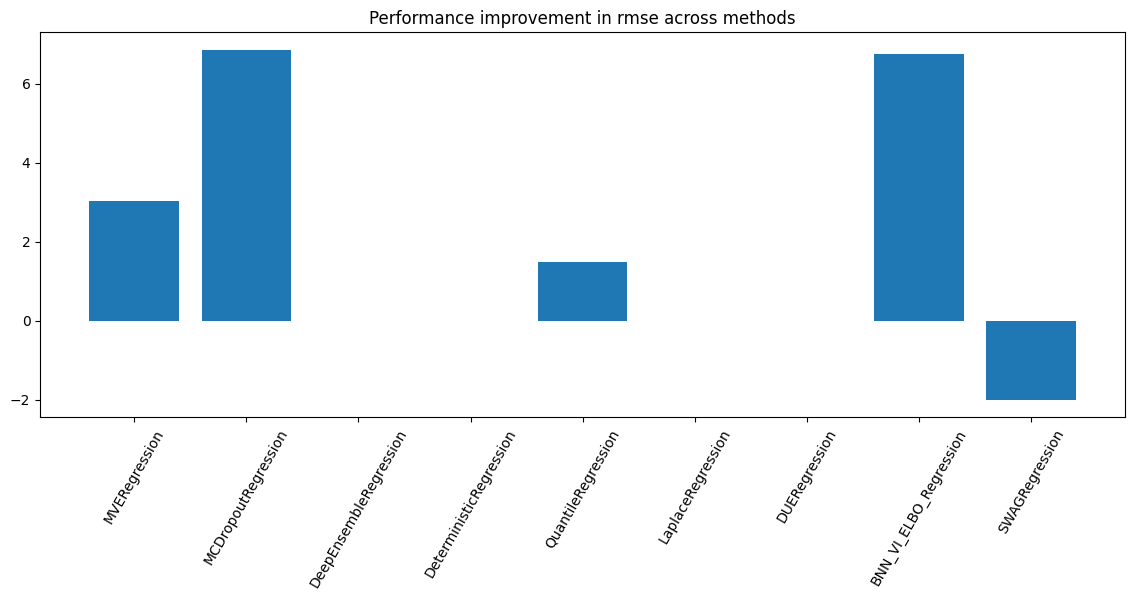

In [14]:
metric = "rmse"
diff_train = diff_df[diff_df["split"]=="preds_train"].reset_index(drop=True)
diff_test = diff_df[diff_df["split"]=="preds_val"].reset_index(drop=True)
fig, ax = plt.subplots(1)
ax.bar(diff_test["uqmethod"].values, diff_test[metric].values)
plt.title(f"Performance improvement in {metric} across methods")
plt.xticks(rotation=60)

In [17]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,tropical_depression,tropical_storm,hurr_1,hurr_2,hurr_3,hurr_4,hurr_5,count_total,uqmethod
0,4.606573,10.223162,5.161234,64.138574,0.377866,0.333156,0.336522,39.521909,8.285149,10.687175,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,4867,1229,664,533,410,78,7781,DER
1,4.598467,9.949671,5.023109,63.515237,0.405641,0.356216,0.359814,39.522941,7.140793,9.327001,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,22983,6187,2932,2495,1978,287,36862,DER
2,4.602965,10.235908,5.167684,63.971199,0.375018,0.330531,0.333870,39.302322,8.442986,11.047232,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,18227,4183,1846,1432,907,138,26733,DER
3,3.756191,5.912059,2.985064,29.477296,0.003937,0.003343,0.003340,10.570501,8.313052,10.861044,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,3678,988,650,482,507,64,6369,MVERegression
4,3.882525,5.375776,2.714409,26.542223,0.020427,0.017806,0.017983,10.216826,7.592528,9.966277,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,24543,6443,2931,2557,1857,296,38627,MVERegression
5,543.604362,6.154736,3.106996,31.449003,0.025208,0.023475,0.023712,10.165235,8.615573,11.406542,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,18227,4183,1846,1432,907,138,26733,MVERegression
6,3.807661,5.949520,3.004106,30.009727,0.101929,0.089769,0.090676,13.968560,8.288371,10.443262,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,4170,1171,502,508,415,74,6840,MCDropoutRegression
7,3.714017,5.100492,2.575299,27.147591,0.180817,0.161358,0.162988,14.087503,6.676813,8.655147,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,23936,6223,3093,2534,1968,284,38038,MCDropoutRegression
8,3.854889,6.404481,3.233859,32.040364,0.080925,0.070172,0.070881,14.029459,9.003944,11.562459,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,18227,4183,1846,1432,907,138,26733,MCDropoutRegression
9,3.798193,5.246180,2.648789,29.065475,0.226398,0.202571,0.204617,15.910788,6.413287,8.284360,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,4666,1588,704,577,341,50,7926,DeepEnsembleRegression


The number of samples being removed per category as a percentage.

In [18]:
sample_remain_pct = (uq_metric_df[CLASS_LABELS+["count_total"]] - selective_df[CLASS_LABELS+["count_total"]]) / uq_metric_df[CLASS_LABELS+["count_total"]]
sample_remain_pct.insert(0, ("split"), uq_metric_df["split"])
sample_remain_pct.insert(0, ("UQ Method"), uq_metric_df["uqmethod"])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'DER'),
  Text(1, 0, 'MVERegression'),
  Text(2, 0, 'MCDropoutRegression'),
  Text(3, 0, 'DeepEnsembleRegression'),
  Text(4, 0, 'DeterministicRegression'),
  Text(5, 0, 'QuantileRegression'),
  Text(6, 0, 'LaplaceRegression'),
  Text(7, 0, 'DUERegression'),
  Text(8, 0, 'BNN_VI_ELBO_Regression'),
  Text(9, 0, 'SWAGRegression'),
  Text(10, 0, 'DKLRegression')])

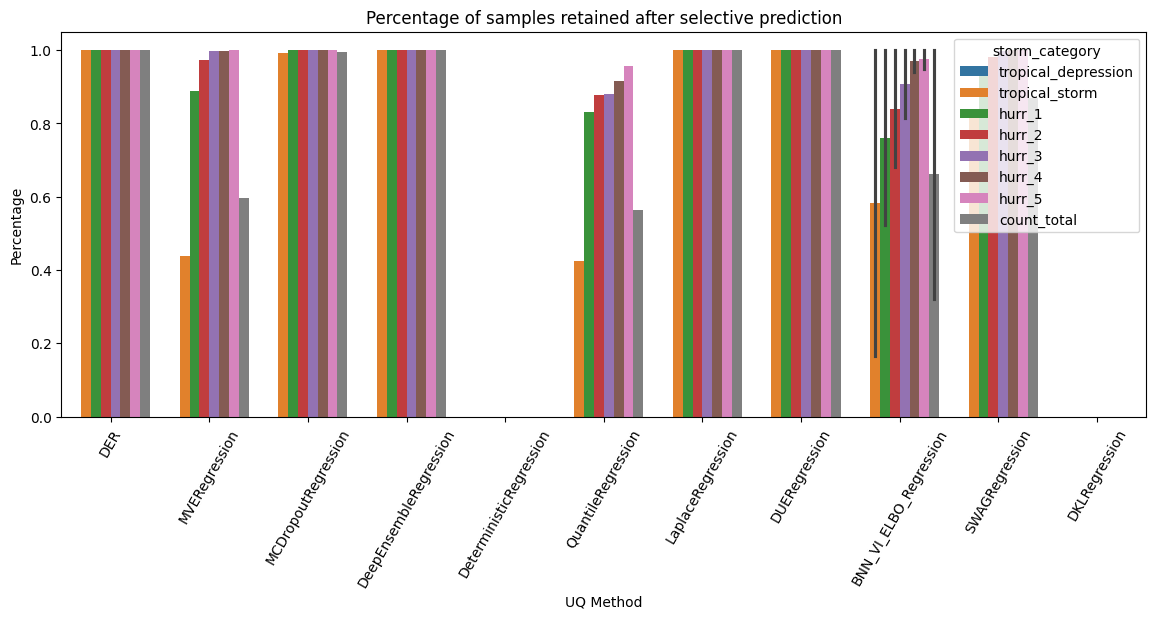

In [19]:
train_count = sample_remain_pct[sample_remain_pct["split"]=="preds_train"].reset_index(drop=True)
train_count = pd.melt(train_count, id_vars="UQ Method", value_vars=CLASS_LABELS+["count_total"], var_name="storm_category")
test_count = sample_remain_pct[sample_remain_pct["split"]=="preds"].reset_index(drop=True)
test_count = pd.melt(test_count, id_vars="UQ Method", value_vars=CLASS_LABELS+["count_total"], var_name="storm_category")
fig, ax = plt.subplots(1)
sns.barplot(x="UQ Method", y="value", hue="storm_category", data=test_count)
plt.ylabel("Percentage")
plt.title("Percentage of samples retained after selective prediction")
plt.xticks(rotation=60)

# All preds in a single DF

In [20]:
overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]
# test_df = overview_df[overview_df["split"]=="preds.csv"].reset_index(drop=True)

all_test_pred_df = []
for idx, row in overview_df.iterrows():
    pred_df = pd.read_csv(row["pred_path"])
    pred_df["uqmethod"] = row["uqmethod"]
    pred_df["split"] = row["split"]
    pred_df["pred_path"] = row["pred_path"]
    # pred_df['base_dir'] = pred_df['pred_path'].apply(os.path.dirname)
    # pred_df["target_mean"], pred_df["target_std"] = pred_df["pred_path"].apply(get_normalization_params_from_df)
    # pred_df.drop(columns="base_dir", inplace=True)
    all_test_pred_df.append(pred_df)

from scipy import stats
# test_df = overview_df[overview_df["split"]=="preds"]

all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)

def get_normalization_params(group):
    pred_path = group['pred_path'].iloc[0]
    TARGET_MEAN, TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_mean"], NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_std"]
    group['target_mean'] = TARGET_MEAN
    group['target_std'] = TARGET_STD
    return group

all_test_pred_df = all_test_pred_df.groupby('pred_path').apply(get_normalization_params)

# normalize
all_test_pred_df["pred"] = (all_test_pred_df["pred"] * all_test_pred_df["target_std"]) + all_test_pred_df["target_mean"]
all_test_pred_df["target"] = (all_test_pred_df["target"] * all_test_pred_df["target_std"]) + all_test_pred_df["target_mean"]
all_test_pred_df["pred_uct"] = all_test_pred_df["pred_uct"] * all_test_pred_df["target_std"]

all_test_pred_df['storm_category'] = pd.cut(all_test_pred_df['target'], bins=BIN_EDGES, labels=CLASS_LABELS, right=False)
all_test_pred_df["mse"] = (all_test_pred_df["pred"] - all_test_pred_df["target"])**2
all_test_pred_df["mae"] = np.abs(all_test_pred_df["pred"] - all_test_pred_df["target"])
all_test_pred_df["nll"] = -1 * stats.norm.logpdf(all_test_pred_df["pred"] - all_test_pred_df["target"], scale=all_test_pred_df["pred_uct"])

# date
pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

# Extract dates and create a new column
all_test_pred_df['date'] = all_test_pred_df['pred_path'].str.extract(pattern)

# Convert the new_date_column to datetime format
all_test_pred_df['date'] = pd.to_datetime(all_test_pred_df['date'], format='%m-%d-%Y_%H-%M')

all_test_pred_df = all_test_pred_df.reset_index(drop=True)
all_test_pred_df = all_test_pred_df.dropna(subset=["mse", "mae"], how='any')
all_test_pred_df

,pred,pred_uct,aleatoric_uct,epistemic_uct,target,uqmethod,split,pred_path,lower_quant,upper_quant,target_mean,target_std,storm_category,mse,mae,nll,date
0,42.227942,6.863752,NaN,0.268848,34.999999,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,52.243150,7.227942,3.399660,NaT
1,43.979502,6.800354,NaN,0.266364,34.999999,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,80.631472,8.979503,3.707703,NaT
2,45.157270,6.906914,NaN,0.270538,40.000000,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,26.597436,5.157270,3.130229,NaT
3,46.467198,7.545144,NaN,0.295537,40.000000,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,41.824656,6.467198,3.307182,NaT
4,47.002948,8.030276,NaN,0.314539,40.000000,BNN_VI_ELBO_Regression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,49.041279,7.002948,3.382409,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857716,154.184193,18.260386,0.708398,0.098729,155.000002,SWAGRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,hurr_5,0.665545,0.815810,3.824671,NaT
857717,51.724977,14.789833,0.578792,0.024403,55.000000,SWAGRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,10.725777,3.275023,3.637396,NaT
857718,38.915900,13.845651,0.541167,0.035395,34.999999,SWAGRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,15.334278,3.915901,3.586905,NaT
857719,43.723687,13.604389,0.531928,0.031717,44.999999,SWAGRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,1.628972,1.276312,3.533732,NaT


In [21]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]

,pred,pred_uct,aleatoric_uct,epistemic_uct,target,uqmethod,split,pred_path,lower_quant,upper_quant,target_mean,target_std,storm_category,mse,mae,nll,date
428231,34.798852,NaN,NaN,NaN,34.999999,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,0.040460,0.201148,NaN,NaT
428232,35.264542,NaN,NaN,NaN,34.999999,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,0.069983,0.264542,NaN,NaT
428233,41.454788,NaN,NaN,NaN,40.000000,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,2.116408,1.454788,NaN,NaT
428234,33.235470,NaN,NaN,NaN,40.000000,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,45.758868,6.764530,NaN,NaT
428235,41.642825,NaN,NaN,NaN,40.000000,DeterministicRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,2.698874,1.642825,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499794,51.817154,NaN,NaN,NaN,44.999999,DeterministicRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,46.473597,6.817155,NaN,NaT
499795,71.190588,NaN,NaN,NaN,90.000000,DeterministicRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,hurr_2,353.793955,18.809411,NaN,NaT
499796,53.371452,NaN,NaN,NaN,57.000000,DeterministicRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,13.166361,3.628548,NaN,NaT
499797,57.487038,NaN,NaN,NaN,60.000000,DeterministicRegression,preds_val.csv,/p/project/hai_uqmethodbox/experiment_output/s...,NaN,NaN,61.754425,25.53027,tropical_storm,6.314976,2.512962,NaN,NaT


In [22]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]["uqmethod"].unique()

array(['DeterministicRegression'], dtype=object)

In [23]:
all_test_pred_df.target.min()

33.99999918491821

## Dataframe with Metrics per Category

In [24]:
group_cols = ["uqmethod", "pred_path", "storm_category"]
category_df = all_test_pred_df.groupby(by=group_cols, observed=False)[["mse", "mae", "nll", "pred_uct"]].mean()
category_df.reset_index(inplace=True)
category_df.rename(columns={"pred_uct": "sharpness"}, inplace=True)
category_df["rmse"] = category_df["mse"] ** 0.5
category_df['split'] = category_df['pred_path'].str.rsplit('/', n=1).str[-1].str.rsplit(".").str[0]
category_df["contains"] = [x[0] in x[1] for x in zip(category_df['uqmethod'], category_df['pred_path'])]
category_df = category_df[category_df["contains"]==True]

category_df = category_df[~((category_df['uqmethod'] == 'MCDropoutRegression') & category_df['rmse'].isna())]
category_df = category_df[~((category_df['uqmethod'] == 'DKLRegression') & category_df['rmse'].isna())]
# category_df = category_df[~((category_df['uqmethod'] == 'BaseModel') & category_df['rmse'].isna())]

del category_df["contains"]
# compute other metrics of interest
quantile = 0.95
result = all_test_pred_df[all_test_pred_df["uqmethod"]!="DeterministicRegression"].groupby(group_cols, observed=False).apply(lambda x: uct.get_proportion_in_interval(x["pred"].values, x['pred_uct'].values, x['target'].values, quantile=quantile)).reset_index()
result.rename(columns={0: f"proportion_in_{quantile}_interval"}, inplace=True)

category_df = pd.merge(category_df, result, how="left", left_on=group_cols, right_on=group_cols)

columns_to_check = ["mse", "mae", "nll", "sharpness", "rmse"]
category_df = category_df.dropna(subset=columns_to_check)
category_df

,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/s...,tropical_storm,79.360239,7.272777,3.579932,9.052573,8.908436,preds,0.968399
2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/s...,hurr_1,196.568987,12.198302,4.462922,12.537498,14.020306,preds,0.825006
3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/s...,hurr_2,610.159836,23.437678,5.743788,15.545707,24.701414,preds,0.643012
4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/s...,hurr_3,1101.653954,30.878750,6.858051,19.281114,33.191173,preds,0.566341
5,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/s...,hurr_4,1614.081332,37.617298,6.756737,23.410199,40.175631,preds,0.638368
...,...,...,...,...,...,...,...,...,...,...
241,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/s...,hurr_1,138.919636,9.202363,4.011342,16.826090,11.786417,preds_val,0.983071
242,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/s...,hurr_2,213.507277,11.259061,4.145685,16.971271,14.611888,preds_val,0.952174
243,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/s...,hurr_3,136.971588,8.532503,3.976278,17.143681,11.703486,preds_val,0.990138
244,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/s...,hurr_4,96.797852,7.685556,3.918529,17.153472,9.838590,preds_val,0.994083


In [25]:
with pd.option_context('display.max_colwidth', None):
    display(category_df[category_df["uqmethod"]=="DKLRegression"])


,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
63,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds.csv,tropical_storm,98.378815,7.869437,3.924192,17.045166,9.918610,preds,0.995227
64,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds.csv,hurr_1,239.422681,12.837638,4.165866,17.038074,15.473289,preds,0.978962
65,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds.csv,hurr_2,354.528012,15.495989,4.364563,17.064700,18.828914,preds,0.937703
66,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds.csv,hurr_3,427.819969,16.146113,4.496146,17.174436,20.683809,preds,0.852654
67,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds.csv,hurr_4,463.023383,15.351489,4.562857,17.521570,21.517978,preds,0.862183
68,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds.csv,hurr_5,1147.325501,32.728540,5.544725,18.313924,33.872194,preds,0.710145
69,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds_train.csv,tropical_storm,98.622390,7.849432,3.924508,17.042021,9.930881,preds_train,0.994859
70,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds_train.csv,hurr_1,180.695835,11.114967,4.065287,17.036409,13.442315,preds_train,0.993294
71,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds_train.csv,hurr_2,305.634604,14.601143,4.280853,17.068074,17.482408,preds_train,0.962873
72,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/sgd_check/cyclone_DKLRegression_12-18-2023_16-22-01-784128/preds_train.csv,hurr_3,262.580599,12.031761,4.213104,17.186033,16.204339,preds_train,0.918695


In [27]:
# Make latex table
metric_columns = ["rmse", "nll"]

table_labels = category_df["storm_category"].unique()
print(table_labels)
columns = pd.MultiIndex.from_product([table_labels, metric_columns])
combined_df = pd.DataFrame(columns=columns)

latex_df = category_df[category_df["split"]=="preds_val"]

# combined_df["uqmethod"] = tail_and_gap_selective_df["uqmethod"].unique()
for split in table_labels:
    split_df = latex_df[latex_df["storm_category"]==split]
    for metric in metric_columns:
        combined_df[(split, metric)] = split_df[metric].values

combined_df.insert(0, ("", "uqmethod"), latex_df["uqmethod"].unique())
combined_df= combined_df.round(3)
# print(combined_df)

def as_latex_output(combined_df):
    combined_df = combined_df.round(3)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.3f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("rmse", "rmse $\downarrow$")
    latex_output = latex_output.replace("nll", "nll $\downarrow$")
    # latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrr}", "l|cc|cc|cc|cc|cc")
    latex_output = latex_output.replace("\multicolumn{2}{r}", "\multicolumn{2}{c}")
    latex_output = latex_output.replace("\textbf{BNN\_VI\_ELBO}", "BNN\_VI\_ELBO")
    return latex_output

latex_table = as_latex_output(combined_df)
print(latex_table)

['tropical_storm', 'hurr_1', 'hurr_2', 'hurr_3', 'hurr_4', 'hurr_5']
Categories (7, object): ['tropical_depression' < 'tropical_storm' < 'hurr_1' < 'hurr_2' < 'hurr_3' < 'hurr_4' < 'hurr_5']


ValueError: Length of values (10) does not match length of index (11)

In [28]:
combined_df

tropical_storm               hurr_1               hurr_2            \
             rmse       nll       rmse       nll       rmse       nll   
0        9.267443  3.639933  15.340920  4.788340  24.095992  5.899192   
1        9.764447  3.724967  12.406575  4.384741  17.628182  5.232230   
2        9.213738  4.532820  12.265098  4.687043  13.521771  4.751871   
3       10.183194  3.933292  16.101446  4.201022  19.288939  4.395109   
4        8.577731  3.574470  12.070570  3.992549  12.180016  3.992735   
5        6.813162  3.702848   9.871687  3.926420  11.303742  3.974711   
6        8.374701  4.215839  11.983855  4.271851  15.286374  4.340439   
7        9.855353  3.736669  10.739628  3.907931  12.190240  3.960441   
8        8.433136  3.519115  12.139203  3.995559  14.846871  4.251888   
9        8.266556  3.489695  14.302187  4.559926  13.551420  4.097628   
10       7.851504  3.714394  11.786417  4.011342  14.611888  4.145685   

       hurr_3               hurr_4               hurr_5            
         rmse       nll       rmse       nll       rmse       nll  
0   30.898706  6.092755  32.883898  5.323517  51.354426  6.045777  
1   20.954026  5.641637  27.744118  6.177772  34.795596  6.721580  
2   12.788159  4.760134  12.466834  4.762499  15.343792  4.834833  
3   18.295508  4.336961  15.224133  4.150708  38.584553  5.863885  
4   12.105862  4.001853  14.003572  4.292679  20.785003  5.674567  
5    9.381794  3.907466   7.985156  3.901962  14.241230  4.169233  
6   12.911598  4.289603  15.031769  4.334828  27.811718  4.751457  
7   11.453253  3.904524  10.382110  3.858731  16.410144  4.233643  
8   13.083542  3.984135  13.697256  4.046197  19.051886  4.636898  
9   11.384209  3.839180  13.201050  4.236727  19.369294  5.133136  
10  11.703486  3.976278   9.838590  3.918529  21.331852  4.443103

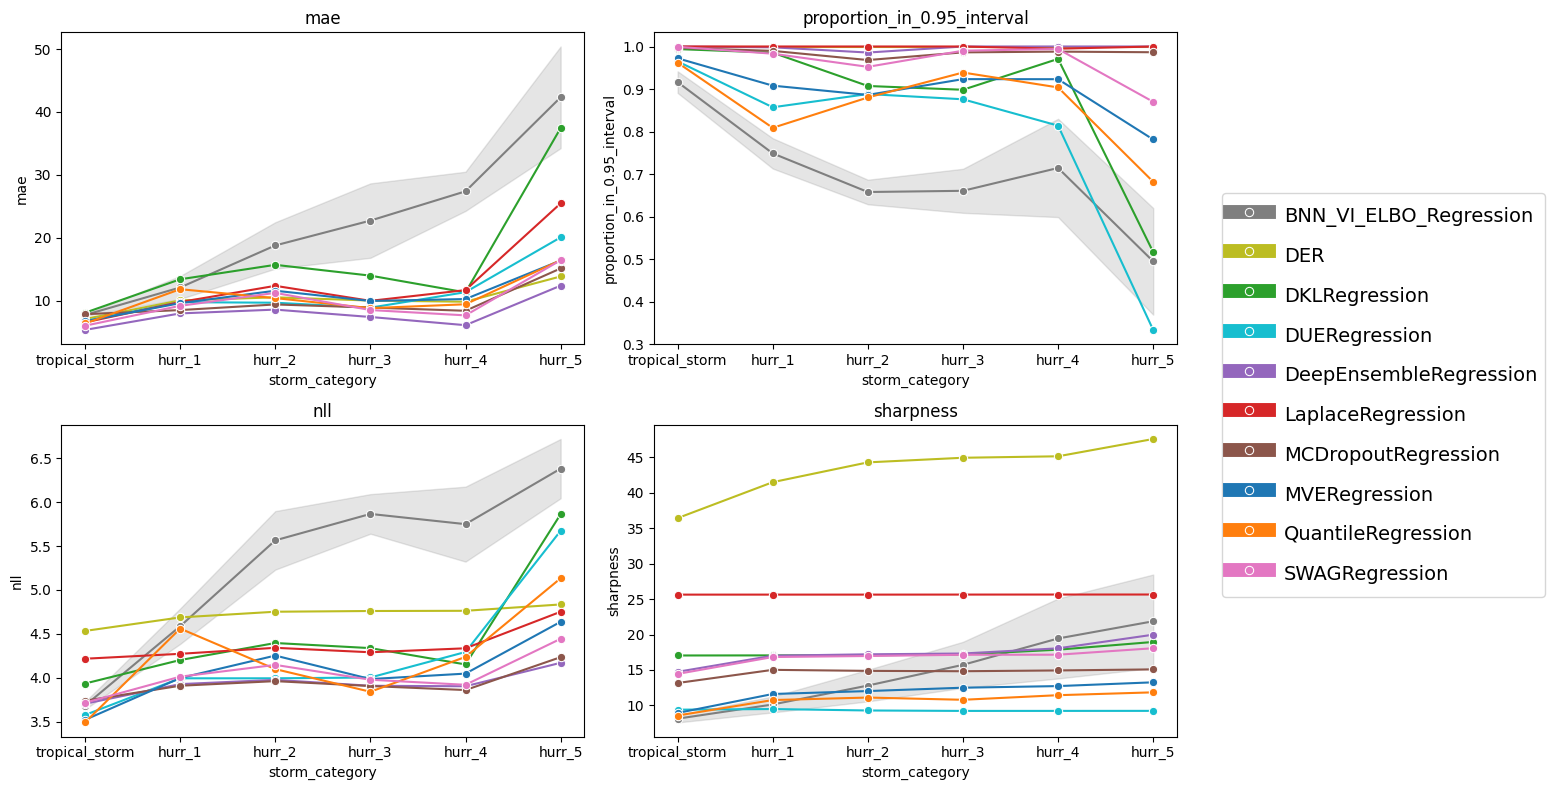

In [29]:
split = "val"

if split == "train":
    plot_cat_df = category_df[category_df["split"] == "preds_train"]
else:
    plot_cat_df = category_df[category_df["split"] == "preds_val"]
# plot per category
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# Assuming 'category' is the column used for x-axis and 'metrics' are the columns to be plotted
metrics = ["mae", "proportion_in_0.95_interval", "nll", "sharpness"]

# Assuming 'methods' is the column used for hue
methods = 'u'
plot_cat_df = plot_cat_df[plot_cat_df["uqmethod"]!="DERModel"]

# Loop through the subplots
for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    
    # Create the sns plot
    sns.lineplot(x='storm_category', y=metric, hue="uqmethod", data=plot_cat_df, ax=axes[row, col], marker="o", palette=color_palette)
    
    # Add title
    axes[row, col].set_title(f'{metric}')
    
    # Add legend
    # axes[row, col].set_xticklabels(present_labels)
    # axes[row, col].legend(loc='upper right')

# set the linewidths to the copies
handles, labels = axes[0,0].get_legend_handles_labels()
[ha.set_linewidth(10) for ha in handles]

    
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.3, 0.5), fontsize=14, handleheight=2)
    
# Remove individual legends
for ax in axes.flat:
    ax.get_legend().remove()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Tables

In [30]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,tropical_depression,tropical_storm,hurr_1,hurr_2,hurr_3,hurr_4,hurr_5,count_total,uqmethod
0,4.606573,10.223162,5.161234,64.138574,0.377866,0.333156,0.336522,39.521909,8.285149,10.687175,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,4867,1229,664,533,410,78,7781,DER
1,4.598467,9.949671,5.023109,63.515237,0.405641,0.356216,0.359814,39.522941,7.140793,9.327001,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,22983,6187,2932,2495,1978,287,36862,DER
2,4.602965,10.235908,5.167684,63.971199,0.375018,0.330531,0.333870,39.302322,8.442986,11.047232,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,18227,4183,1846,1432,907,138,26733,DER
3,3.756191,5.912059,2.985064,29.477296,0.003937,0.003343,0.003340,10.570501,8.313052,10.861044,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,3678,988,650,482,507,64,6369,MVERegression
4,3.882525,5.375776,2.714409,26.542223,0.020427,0.017806,0.017983,10.216826,7.592528,9.966277,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,24543,6443,2931,2557,1857,296,38627,MVERegression
5,543.604362,6.154736,3.106996,31.449003,0.025208,0.023475,0.023712,10.165235,8.615573,11.406542,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,18227,4183,1846,1432,907,138,26733,MVERegression
6,3.807661,5.949520,3.004106,30.009727,0.101929,0.089769,0.090676,13.968560,8.288371,10.443262,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,4170,1171,502,508,415,74,6840,MCDropoutRegression
7,3.714017,5.100492,2.575299,27.147591,0.180817,0.161358,0.162988,14.087503,6.676813,8.655147,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,23936,6223,3093,2534,1968,284,38038,MCDropoutRegression
8,3.854889,6.404481,3.233859,32.040364,0.080925,0.070172,0.070881,14.029459,9.003944,11.562459,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,18227,4183,1846,1432,907,138,26733,MCDropoutRegression
9,3.798193,5.246180,2.648789,29.065475,0.226398,0.202571,0.204617,15.910788,6.413287,8.284360,...,/p/project/hai_uqmethodbox/experiment_output/s...,0,4666,1588,704,577,341,50,7926,DeepEnsembleRegression


In [31]:
category_columns = ["rmse", "nll"]
splits = ["Train", "Test"]

columns = pd.MultiIndex.from_product([splits, category_columns, ["default", "selective", "diff"]])
combined_df = pd.DataFrame(columns=columns)

# combined_df["uqmethod"] = tail_and_gap_selective_df["uqmethod"].unique()
for split in splits:
    if "train" in split.lower():
        table_uq_df = uq_metric_df[uq_metric_df["split"]=="preds_train"]
        table_selective_df = selective_df[selective_df["split"]=="preds_train"]
    else:
        table_uq_df = uq_metric_df[uq_metric_df["split"]=="preds_val"]
        table_selective_df = selective_df[selective_df["split"]=="preds_val"]

    table_uq_df = table_uq_df.groupby("uqmethod")[category_columns].mean().reset_index()
    table_selective_df = table_selective_df.groupby("uqmethod")[category_columns].mean().reset_index()

    for metric in category_columns:
        combined_df[(split, metric, "default")] = table_uq_df[metric]
        combined_df[(split, metric, "selective")] = table_selective_df[metric]
        combined_df[(split, metric, "diff")] = table_uq_df[metric] - table_selective_df[metric]


combined_df.insert(0, ("", "", "uqmethod"), table_uq_df["uqmethod"])
combined_df= combined_df.round(4)

def as_latex_output(combined_df):
    combined_df = combined_df.round(4)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.4f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("diff", "diff $\downarrow$")
    latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrrrr}", "{lccc|ccc|ccc|ccc}")
    latex_output = latex_output.replace("\multicolumn{6}{r}{Train}", "\multicolumn{6}{c}{Train}")
    latex_output = latex_output.replace("\multicolumn{6}{r}{Test}", "\multicolumn{6}{c}{Test}")
    return latex_output

latex_table = as_latex_output(combined_df)
print(latex_table)

\begin{tabular}{lccc|ccc|ccc|ccc}
\toprule
 & \multicolumn{6}{c}{Train} & \multicolumn{6}{c}{Test} \\
 & \multicolumn{3}{c}{rmse} & \multicolumn{3}{c}{nll} & \multicolumn{3}{c}{rmse} & \multicolumn{3}{c}{nll} \\
uqmethod & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ \\
\midrule
\textbf{BNN\_VI\_ELBO\_Regression} & 12.6074 & 7.8305 & 4.7769 & 3.8060 & 3.4976 & 0.3084 & 15.7630 & 10.9478 & 4.8152 & 4.3083 & 4.0508 & 0.2575 \\
DER & 9.3270 & NaN & NaN & 4.5985 & NaN & NaN & 10.6872 & NaN & NaN & 4.6066 & NaN & NaN \\
DKLRegression & 12.4411 & NaN & NaN & 4.0209 & NaN & NaN & 14.5641 & NaN & NaN & 4.1098 & NaN & NaN \\
DUERegression & \textbf{2.6265} & NaN & NaN & \textbf{3.1829} & NaN & NaN & 10.3129 & NaN & NaN & 3.7645 & NaN & NaN \\
DeepEnsembleRegression & 8.8839 & NaN &

## Metric Computation per Category

In [32]:
category_columns = ["rmse", "nll", "sharpness"]
splits = [""]

columns = pd.MultiIndex.from_product([splits, category_columns, ["default", "selective", "diff"]])
combined_df = pd.DataFrame(columns=columns)


## Error Analysis per Category

In [33]:
all_test_pred_df[all_test_pred_df["storm_category"]=="tropical_depression"]

,pred,pred_uct,aleatoric_uct,epistemic_uct,target,uqmethod,split,pred_path,lower_quant,upper_quant,target_mean,target_std,storm_category,mse,mae,nll,date


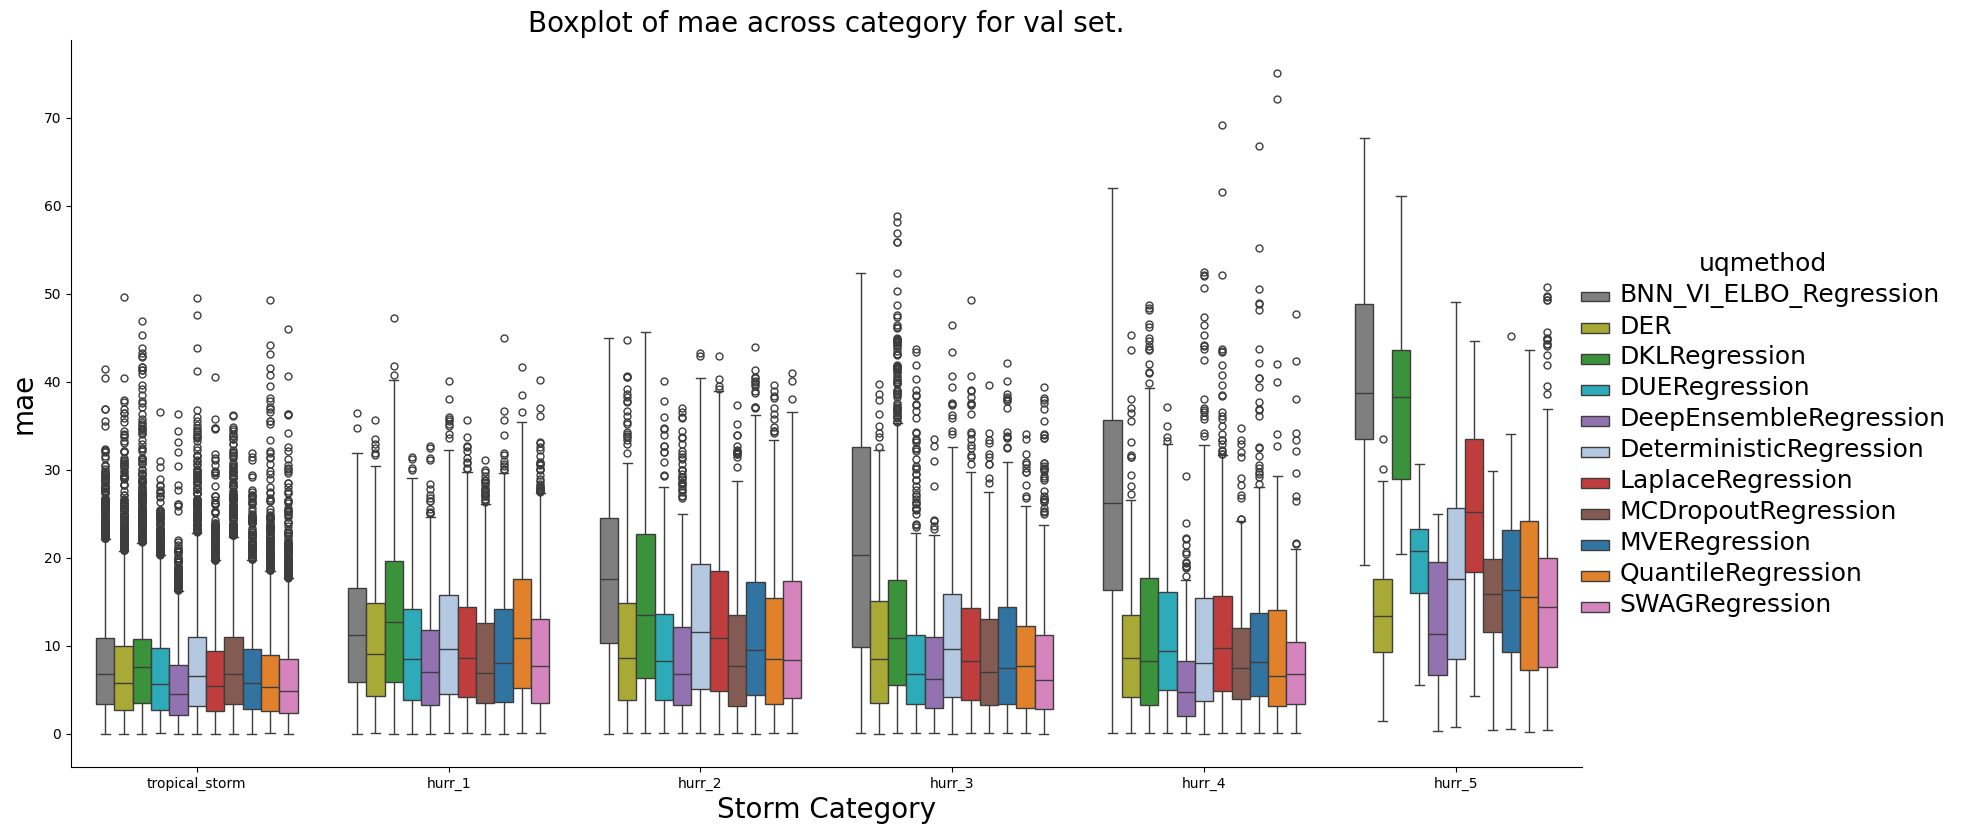

In [34]:
split = "val"
metric = "mae"
plot_df = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}.csv"]
# remove categories with no predictions
mask = plot_df.groupby("storm_category", observed=False)["mae"].transform(lambda x: x.isna().any())
plot_df = plot_df[~mask]
plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()
g = sns.catplot(plot_df, kind="box", x="storm_category", y=metric, hue="uqmethod", height=8, aspect=2, palette=color_palette)

ax = g.ax

# Add horizontal lines behind each x value group
for i, artist in enumerate(ax.artists):
    if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
        artist.set_edgecolor('black')  # Set the edge color to black


# true_test_means = full_df[full_df["split"]=="test"].groupby("storm_category")["wind_speed"].mean().values
# print(true_test_means)
# pos_idx = np.linspace(0.1, 0.9, len(true_test_means))
# # Add additional horizontal lines using axhline
# for i, val in enumerate(true_test_means):
#     print(i, val)
#     ax.axhline(y=val, xmin=pos_idx[i]-0.1, xmax=pos_idx[i]+0.1, color='red', linestyle='--', linewidth=2) 

plt.title(f"Boxplot of {metric} across category for {split} set.", fontsize=20)
plt.ylabel(f"{metric}", fontsize=20)
plt.xlabel("Storm Category", fontsize=20)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))

# Selective prediction per Storm Category

In [35]:
from sklearn.metrics import mean_squared_error


split = "val"

rmse_all = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}.csv"].groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
rmse_all.columns = ['uqmethod', 'storm_category', 'RMSE_All']

# Filter data where uncertainty is less than the threshold
df_filtered = all_test_pred_df[all_test_pred_df["uqmethod"]!="DeterministicRegression"].groupby(['pred_path', 'storm_category'], observed=False).apply(
    lambda group: group[group['pred_uct'] < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]]
).reset_index(drop=True)

# Compute RMSE per method and category over filtered predictions
rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
rmse_filtered.columns = ['uqmethod', 'storm_category', 'RMSE_Uncertainty_Less_Threshold']

# Merge the two DataFrames on method and category
summary_table = pd.merge(rmse_all, rmse_filtered, on=['uqmethod', 'storm_category'], how='left')

# If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
summary_table.fillna({'RMSE_Uncertainty_Less_Threshold': np.nan}, inplace=True)

summary_table['pct_change'] = ((summary_table['RMSE_Uncertainty_Less_Threshold'] - summary_table['RMSE_All']) / summary_table['RMSE_All']) * 100
summary_table["abs_change"] = np.abs(summary_table['RMSE_Uncertainty_Less_Threshold'] - summary_table['RMSE_All'])
summary_table['abs_change'] = summary_table['abs_change'].fillna(0)


# Display the summary table
print(summary_table)

                  uqmethod  storm_category   RMSE_All  \
0   BNN_VI_ELBO_Regression  tropical_storm   9.507057   
1   BNN_VI_ELBO_Regression          hurr_1  13.502357   
2   BNN_VI_ELBO_Regression          hurr_2  20.042646   
3   BNN_VI_ELBO_Regression          hurr_3  25.498980   
4   BNN_VI_ELBO_Regression          hurr_4  30.048055   
..                     ...             ...        ...   
61          SWAGRegression          hurr_1  11.786417   
62          SWAGRegression          hurr_2  14.611888   
63          SWAGRegression          hurr_3  11.703486   
64          SWAGRegression          hurr_4   9.838590   
65          SWAGRegression          hurr_5  21.331852   

    RMSE_Uncertainty_Less_Threshold  pct_change  abs_change  
0                          7.246581  -23.776821    2.260476  
1                         13.464063   -0.283613    0.038294  
2                         22.476553   12.143643    2.433907  
3                         31.815350   24.771070    6.316370  
4    

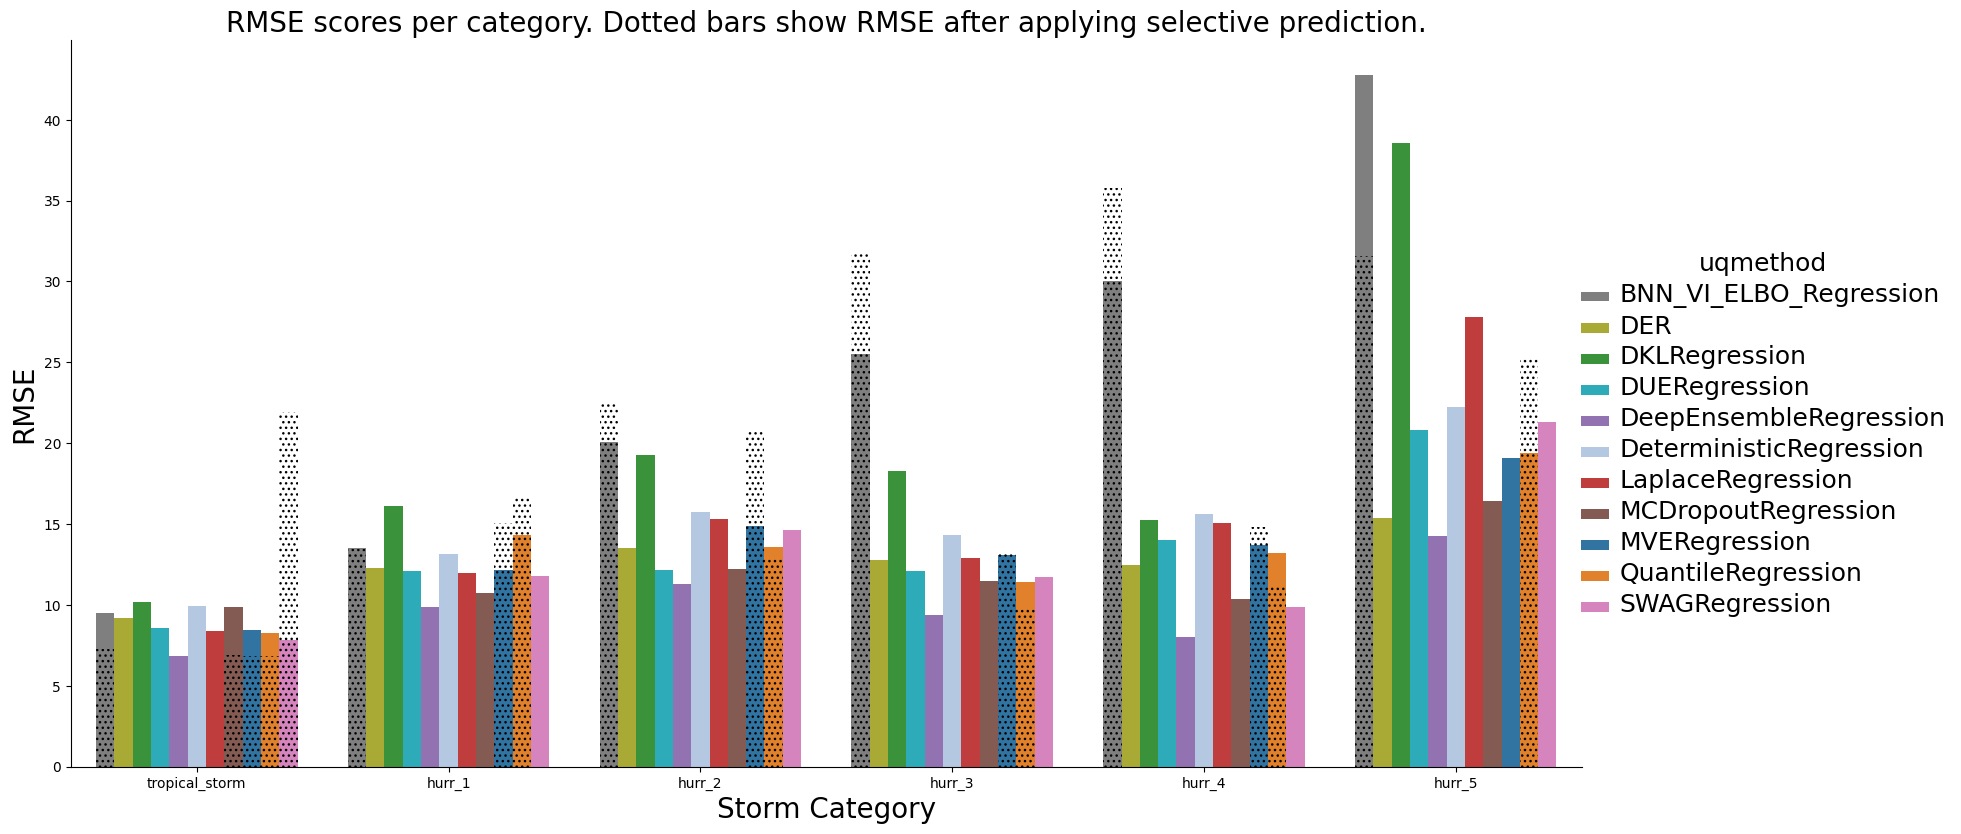

In [36]:
hue_order = summary_table["uqmethod"].unique().tolist()
# remove categories with no predictions

summary_table["storm_category"] = summary_table["storm_category"].cat.remove_unused_categories()
g = sns.catplot(summary_table, kind="bar", x="storm_category", y="RMSE_All", hue="uqmethod", height=8, aspect=2, palette=color_palette, hue_order=hue_order)

ax = g.ax

sns.barplot(summary_table, x="storm_category", y="RMSE_Uncertainty_Less_Threshold", hue="uqmethod", alpha=0.0, ax=ax, hatch="...", hue_order=hue_order)

ax.get_legend().remove()
plt.title("RMSE scores per category. Dotted bars show RMSE after applying selective prediction.", fontsize=20)
plt.ylabel("RMSE", fontsize=20)
plt.xlabel("Storm Category", fontsize=20)

plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))


In [37]:
# sharpness
rmse_all = all_test_pred_df.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
rmse_all.columns = ['uqmethod', 'storm_category', 'SHARP_All']

# Filter data where uncertainty is less than the threshold
df_filtered = all_test_pred_df[all_test_pred_df["uqmethod"]!="DeterministicRegression"].groupby('pred_path').apply(
    lambda group: group[group['pred_uct'] < SELECTIVE_PRED_DICT[os.path.dirname(group.name)]]
).reset_index(drop=True)

# Compute RMSE per method and category over filtered predictions
rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
rmse_filtered.columns = ['uqmethod', 'storm_category', 'SHARP_Uncertainty_Less_Threshold']

# Merge the two DataFrames on method and category
summary_table = pd.merge(rmse_all, rmse_filtered, on=['uqmethod', 'storm_category'], how='left')

# If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
summary_table.fillna({'SHARP_Uncertainty_Less_Threshold': np.nan}, inplace=True)

summary_table['pct_change'] = ((summary_table['SHARP_Uncertainty_Less_Threshold'] - summary_table['SHARP_All']) / summary_table['SHARP_All']) * 100
summary_table["abs_change"] = np.abs(summary_table['SHARP_Uncertainty_Less_Threshold'] - summary_table['SHARP_All'])
summary_table['abs_change'] = summary_table['abs_change'].fillna(0)

TypeError: '<' not supported between instances of 'float' and 'dict'

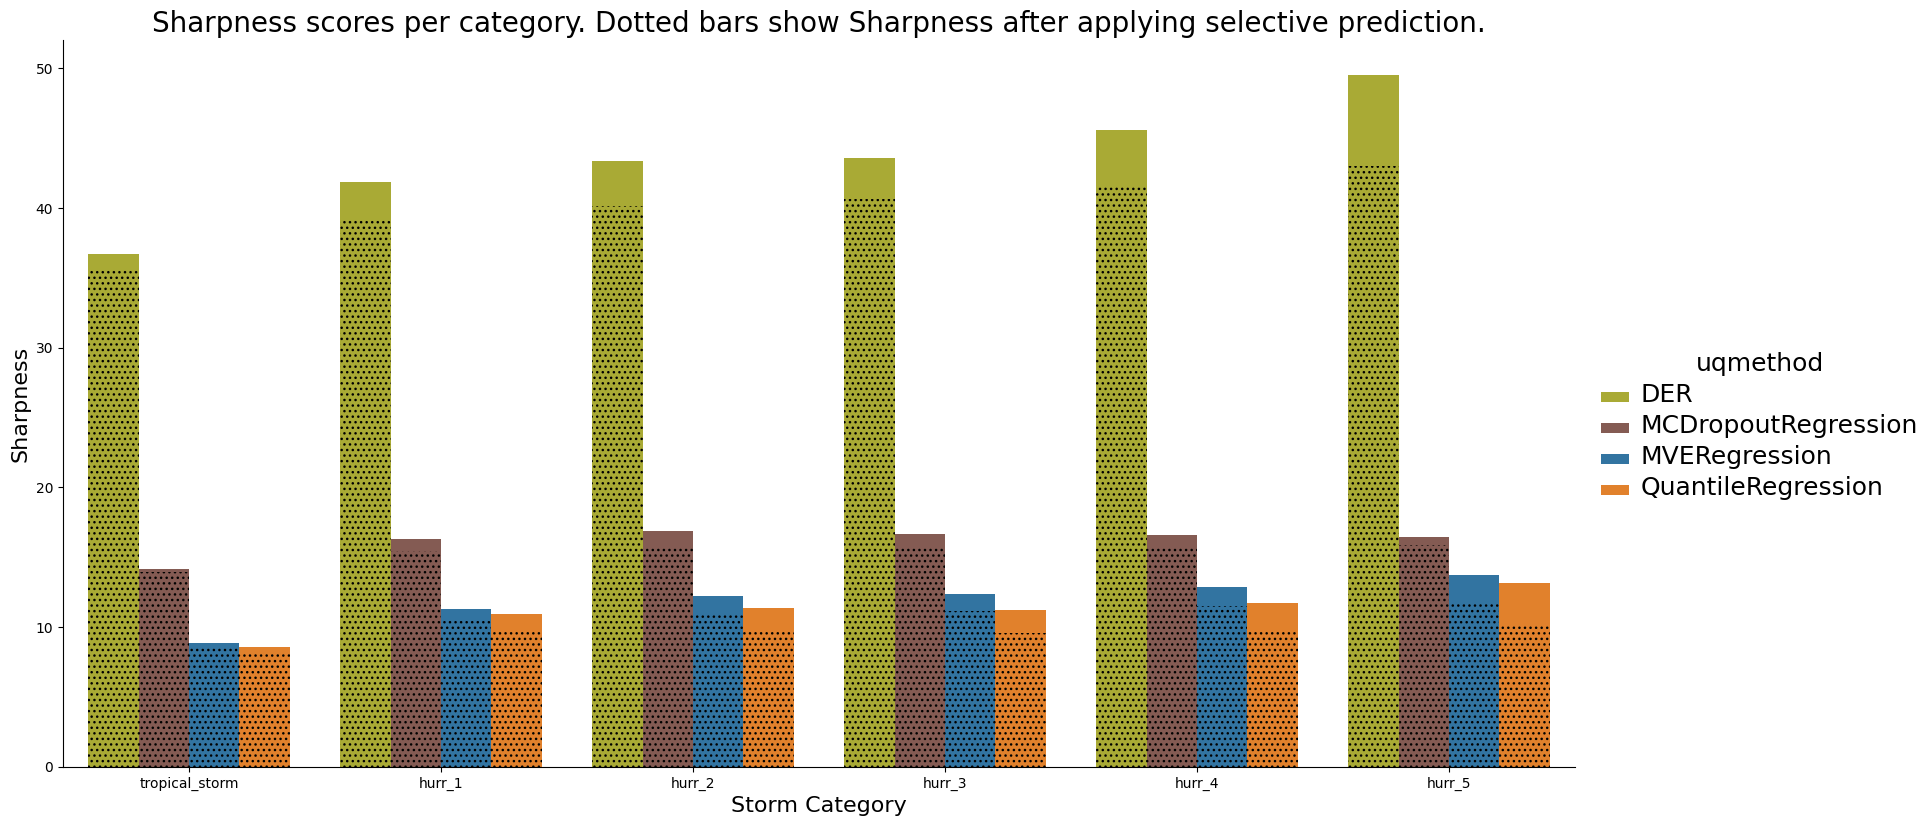

In [ ]:
hue_order = summary_table[summary_table["uqmethod"]!="DERModel"]["uqmethod"].unique().tolist()
summary_table["storm_category"] = summary_table["storm_category"].cat.remove_unused_categories()
g = sns.catplot(summary_table[summary_table["uqmethod"]!="DERModel"], kind="bar", x="storm_category", y="SHARP_All", hue="uqmethod", height=8, aspect=2, palette=color_palette, hue_order=hue_order)

ax = g.ax

sns.barplot(summary_table, x="storm_category", y="SHARP_Uncertainty_Less_Threshold", hue="uqmethod", alpha=0.0, ax=ax, hatch="...", hue_order=hue_order)

ax.get_legend().remove()
plt.title("Sharpness scores per category. Dotted bars show Sharpness after applying selective prediction.", fontsize=20)
plt.ylabel("Sharpness", fontsize=16)
plt.xlabel("Storm Category", fontsize=16)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))

# Calibration

In [38]:
from typing import Union, List, Any
from matplotlib.axes import Axes
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists,
    get_proportion_lists_vectorized,
    adversarial_group_calibration,
    miscalibration_area,
    miscalibration_area_from_proportions,
)


def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list


# TODO Look up color pallete value
def plot_calibration(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    split_name: str,
    n_subset: Union[int, None] = None,
    curve_label: Union[str, None] = None,
    vectorized: bool = True,
    exp_props: Union[np.ndarray, None] = None,
    obs_props: Union[np.ndarray, None] = None,
    ax: Union[Axes, None] = None,
    prop_type: str = "interval",
) -> Axes:
    """Plot the observed proportion vs prediction proportion of outputs falling into a
    range of intervals, and display miscalibration area.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        n_subset: Number of points to plot after filtering.
        curve_label: legend label str for calibration curve.
        vectorized: plot using get_proportion_lists_vectorized.
        exp_props: plot using the given expected proportions.
        obs_props: plot using the given observed proportions.
        ax: matplotlib.axes.Axes object.
        prop_type: "interval" to measure observed proportions for centered prediction intervals,
                   and "quantile" for observed proportions below a predicted quantile.
                   Ignored if exp_props and obs_props are provided as inputs.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true] = filter_subset([y_pred, y_std, y_true], n_subset)

    if (exp_props is None) or (obs_props is None):
        # Compute exp_proportions and obs_proportions
        if vectorized:
            (exp_proportions, obs_proportions) = get_proportion_lists_vectorized(
                y_pred, y_std, y_true, prop_type=prop_type
            )
        else:
            (exp_proportions, obs_proportions) = get_proportion_lists(
                y_pred, y_std, y_true, prop_type=prop_type
            )
    else:
        # If expected and observed proportions are given
        exp_proportions = np.array(exp_props).flatten()
        obs_proportions = np.array(obs_props).flatten()
        if exp_proportions.shape != obs_proportions.shape:
            raise RuntimeError("exp_props and obs_props shape mismatch")

    # Set label
    if curve_label is None:
        curve_label = "Predictor"

    # Plot
    ax.plot([0, 1], [0, 1], "--", c="gray")
    ax.plot(
        exp_proportions, obs_proportions, label=curve_label.replace("Model", ""), c=color_palette[curve_label]
    )  # , c="#1f77b4")
    # ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.1)

    # Format plot
    ax.set_xlabel("Predicted Proportion in Interval", fontsize=16)
    ax.set_ylabel("Observed Proportion in Interval", fontsize=16)
    ax.axis("square")

    buff = 0.01
    ax.set_xlim([0 - buff, 1 + buff])
    ax.set_ylim([0 - buff, 1 + buff])

    ax.set_title(f"Avg Calibration {split_name}", fontsize=16)

    # Compute miscalibration area
    miscalibration_area = miscalibration_area_from_proportions(
        exp_proportions=exp_proportions, obs_proportions=obs_proportions
    )

    # Annotate plot with the miscalibration area
    # ax.text(
    #     x=0.95,
    #     y=0.05,
    #     s="Miscalibration area = %.2f" % miscalibration_area,
    #     verticalalignment="bottom",
    #     horizontalalignment="right",
    #     fontsize="small",
    # )

    return ax

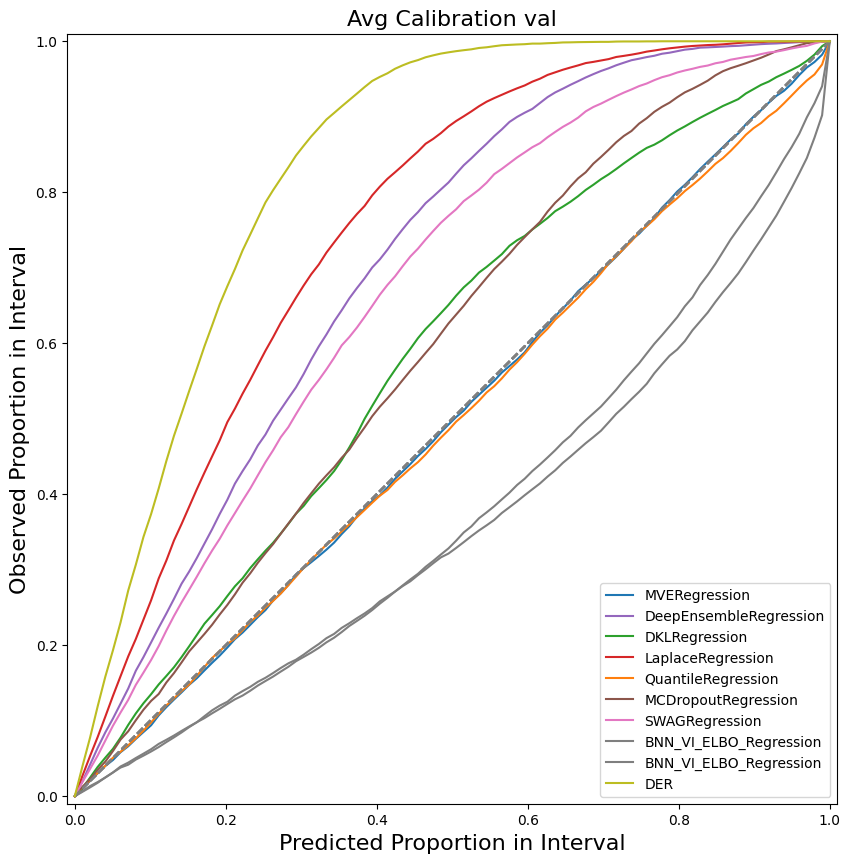

In [39]:
uq_methods_to_show = [
    "MVERegression",
    "DeepEnsembleRegression",
    "DKLRegression",
    "LaplaceRegression",
    "ConformalQR",
    "QuantileRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "BNN_VI_ELBO_Regression",
    "DER",
]

split = "val"

fig, axs = plt.subplots(1, figsize=(10,10))
for idx_uq, uq_method in enumerate(uq_methods_to_show):
    plot_df = uq_metric_df[uq_metric_df["uqmethod"] == uq_method].copy()
    if split == "train":
        plot_df = plot_df[plot_df["split"]=="preds_train"]
    else:
        plot_df = plot_df[plot_df["split"]=="preds_val"]
    plot_df.sort_values(by="split", inplace=True)
    plot_df.reset_index(inplace=True)
    # for idx, pred_path in enumerate(plot_df["pred_path"].unique()):
    for idx, row in plot_df.iterrows():
        split_df = pd.read_csv(row["pred_path"])
        if "pred_uct" in split_df.columns:
            plot_calibration(
                split_df["pred"].values.squeeze(),
                split_df["pred_uct"].values.squeeze(),
                split_df["target"].values.squeeze(),
                ax=axs,
                curve_label=uq_method,
                split_name=split
            )
plt.legend()

# Data Exploration

In [ ]:
from tropical_cyclone_ds import TropicalCycloneSequence

path = "/p/project/hai_uqmethodbox/data/tropical_cyclone"

train_ds = TropicalCycloneSequence(root=path)

Num samples: 69269


In [ ]:
for i in range(len(train_ds)):
    sample = train_ds[i]
    if int(sample["wind_speed"]) > 0:
        train_ds.plot(sample)
        break
# train_ds[0].keys()

KeyError: 'wind_speed'

In [ ]:
def retrieve_item(item, ds):
    source_id = item["href"].split("/")[0]
    if "train_source" in source_id:
        split = "train"
    else:
        split = "test"

    directory = os.path.join(
        ds.root,
        "_".join([train_ds.collection_id, split, "{0}"]),
        source_id.replace("source", "{0}"),
    )
    features = ds._load_features(directory)
    data = {"path": source_id, **features}
    # don't nee the tensor label, already includes 'wind_speed'
    data.pop("label")
    # but add original split where it is coming from
    data["split"] = split
    return data

def retrieve_collection_df(ds):
    def parallel_process(items, ds, num_processes: int):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        read_items = pool.starmap(retrieve_item, [(item, ds) for item in items])
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        df = pd.DataFrame.from_dict(read_items)
        return df
    
    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities
    items = [item for item in ds.collection]
    # Call the parallel_process function to execute the processing in parallel
    df = parallel_process(items, ds, num_processes)

    return df

In [ ]:
train_df = retrieve_collection_df(train_ds)
test_df = retrieve_collection_df(test_ds)

In [ ]:
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df["wind_speed"] = full_df["wind_speed"].astype(int)

full_df['storm_category'] = pd.cut(full_df['wind_speed'], bins=bins, labels=labels, right=False)
full_df
                     

## Wind Speed across splits

In [ ]:
fig, axs = plt.subplots(1)
sns.violinplot(full_df, x="split", y="wind_speed", ax=axs)
axs.set_title("Wind Speed for train and test split.")

## Wind Speed across categories

In [ ]:
# fig, axs = plt.subplots(1)
sns.catplot(full_df, kind="box", x="storm_category", y="wind_speed", hue="split")
plt.title("Boxplot of wind speeds across category and split")

In [ ]:
fig, axs = plt.subplots(1)
sns.countplot(full_df, x="storm_category", hue="split", ax=axs)
plt.title("Count samples per storm category")

In [ ]:
train_df["wind_speed"].astype(int).values

In [ ]:
from denseweight import DenseWeight
import numpy as np
import torch

target = (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD
dw = DenseWeight(alpha=1.0)
weights = dw.fit(target)


curr_weight = dw(torch.Tensor([0.1]))
type(curr_weight)


In [ ]:
np.save("/p/project/hai_uqmethodbox/nils/lightning-uq-box/experiments/image-regression/configs/tropical_cyclone/target.npy", (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD)